In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [2]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [4]:
def adaboost(X, y, N, max_depth=1):
    n_objects = len(X)
    n_classes = len(np.unique((y)))
    w = np.ones(n_objects) / n_objects

    models = []

    for n in range(N):
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        if e >= 1 - 1 / n_classes:
            break

        if e > 0:
            alpha = 0.5 * np.log((1 - e) / e)
        else:
            alpha = 0.0

        match = predictions == y

        w[~match] *= np.exp(alpha)

        w /= w.sum()
        models.append((alpha, clf))

    return models


def predict(X, models):
    n_classes = 2
    n_objects = len(X)

    y_pred = np.zeros((n_objects, n_classes))

    for alpha, clf in models:
        prediction = clf.predict(X)
        y_pred[range(n_objects), prediction] += alpha

    y_pred = np.argmax(y_pred, axis=1)

    return y_pred

In [5]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, N=n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

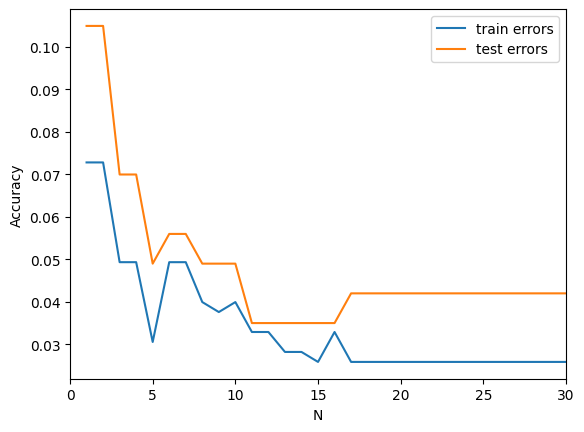

In [6]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

In [7]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, N=15, max_depth=n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

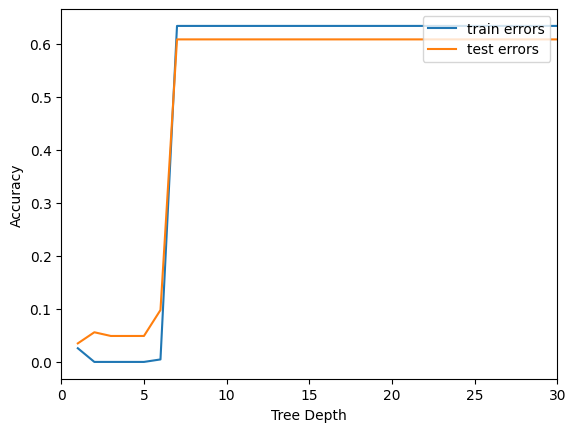

In [8]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

In [9]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])


def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)


def deriv(y, z):
    return 2 * (y - z)


def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees = []

    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if len(trees) == 0:
            tree.fit(X_train, y_train)

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            pred = gb_predict(X_train, trees, coefs, eta)

            tree.fit(X_train, deriv(y_train, pred))

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [10]:
n_trees = 100

train_errors = []
test_errors = []
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

for n_trees in range(1, 21):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

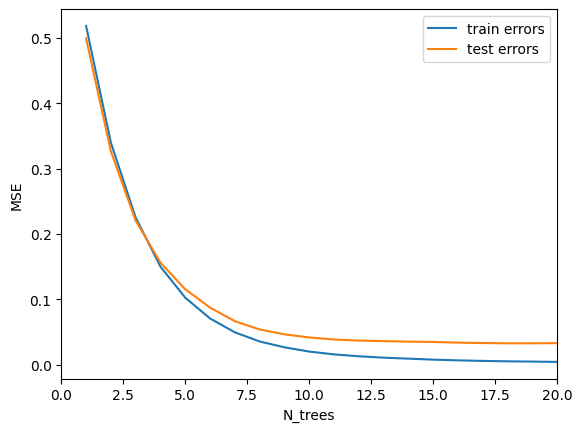

In [11]:
x = list(range(1, 21))

plt.xlim(0, 20)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right');

In [12]:
train_errors = []
test_errors = []
n_trees = 10
coefs = [1] * n_trees
eta = 0.1

for max_depth in range(1, 51):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

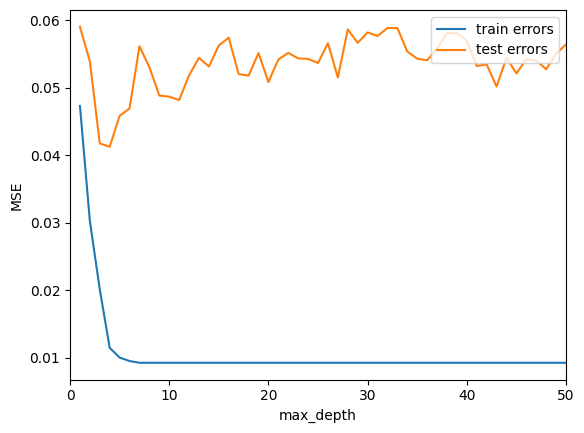

In [13]:
x = list(range(1, 51))

plt.xlim(0, 50)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');